In [1]:
from __future__ import annotations

import math
import os
import pickle
import shutil
from copy import deepcopy
from typing import TypeAlias

from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import preview_contents

In [2]:
Pixel: TypeAlias = tuple[int, int]
PixelArray: TypeAlias = tuple[Pixel]

Point: TypeAlias = tuple[float, float] | Pixel
PointArray: TypeAlias = tuple[Point] | PixelArray

Side: TypeAlias = dict[str, str | PixelArray | PointArray]
Piece: TypeAlias = dict[str, str | PixelArray | PointArray | list[Side]]

# Implementation

## Load data

In [3]:
stage_01_out_path = os.path.join("out", "01", "out.pickle")

with open(stage_01_out_path, "rb") as f:
    DATA = pickle.load(f)

print("Loaded:")
preview_contents(DATA)

print("\nConverting...")
for piece in tqdm(DATA):
    piece["corners"] = tuple(tuple(map(float, point)) for point in piece["corners"])
    piece["contour_pixels"] = tuple(tuple(map(int, pixel)) for pixel in piece["contour_pixels"])  # fmt: skip

print("\nConverted:")
preview_contents(DATA)

Loaded:
[{'contour_pixels': <class 'numpy.ndarray'>,
  'corners': <class 'numpy.ndarray'>,
  'name': <class 'str'>}]

Converting...


100%|██████████| 40/40 [00:00<00:00, 179.07it/s]



Converted:
[{'contour_pixels': ((<class 'int'>,),),
  'corners': ((<class 'float'>,),),
  'name': <class 'str'>}]


In [4]:
SAMPLE = [
    deepcopy(piece)
    for piece in DATA
    if piece["name"] in ["0021", "0024", "0025", "0026", "0008", "0014"]
]

## Preview utils

In [5]:
plt.rcParams.update(
    {
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)


def get_figure(n_axis: int):
    """Create and return pyplot figure."""
    n_cols = 4
    n_rows = math.ceil(n_axis / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols)

    figscale = 3
    fig.set_figwidth(n_cols * figscale)
    fig.set_figheight(n_rows * figscale)
    fig.subplots_adjust(hspace=0.35)
    fig.set_dpi(300)

    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = list(axes.flat)

    for ax in axes:
        ax.set_axis_off()

    return fig, axes


def scatter_plot_lines(ax: plt.Axes, title: str, lines: list[PointArray]) -> None:
    """Plot multiple lines on one axis."""
    x_min = None
    y_min = None
    x_max = None
    y_max = None

    for line in lines:
        if len(line) > 0:
            x = [point[0] for point in line]
            y = [point[1] for point in line]

            if x_min is None or x_min > min(x):
                x_min = min(x)
            if y_min is None or y_min > min(y):
                y_min = min(y)

            if x_max is None or x_max < max(x):
                x_max = max(x)
            if y_max is None or y_max < max(y):
                y_max = max(y)

            ax.scatter(x, y, s=1)

    size = max(x_max - x_min, y_max - y_min)

    margin = 50
    ax.set_xlim(x_min - margin, x_min + size + margin)
    ax.set_ylim(y_min - margin, y_min + size + margin)

    ax.set_title(title)
    ax.grid(True)
    ax.set_axis_on()

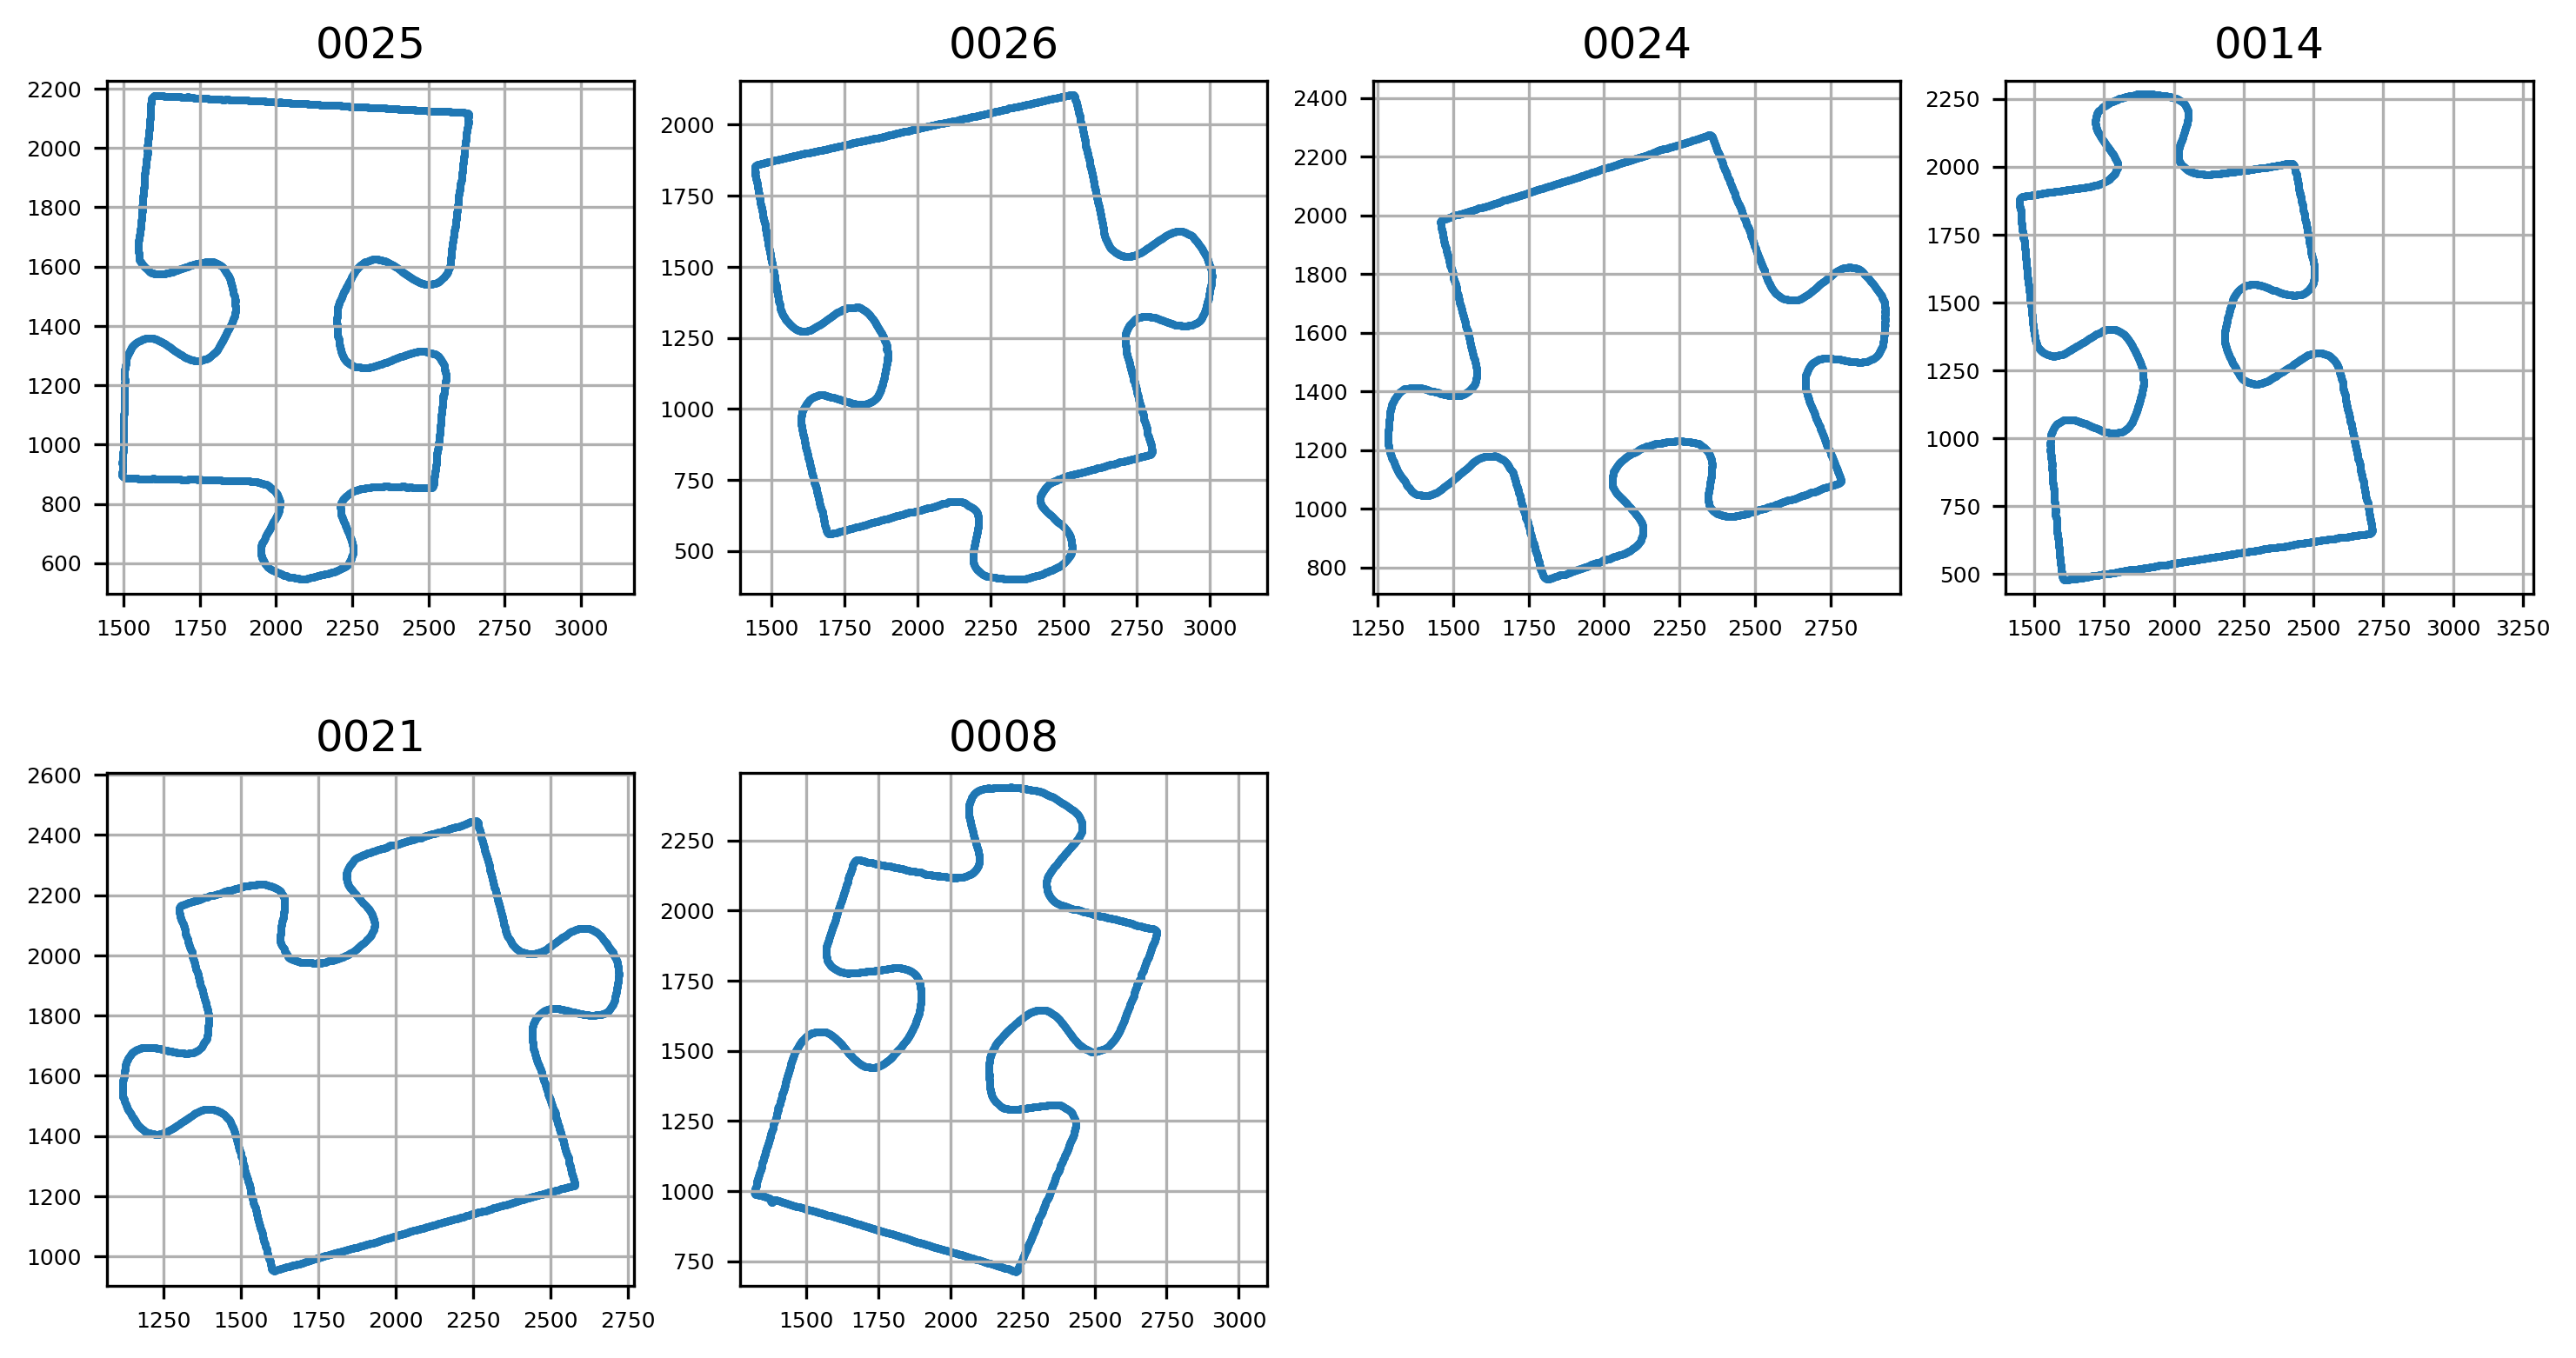

In [6]:
fig, axes = get_figure(len(SAMPLE))
for piece, ax in zip(SAMPLE, axes):
    scatter_plot_lines(ax, piece["name"], [piece["contour_pixels"]])

## Contour pixel classification

The algorithm designed to assign contour pixels to specific sides of a piece by employing a two-step classification process and subsequently determining the type of each side.

**Step 1:**

For each side of the piece, a linear function is generated that passes through the two corners of the side (side function). The algorithm then assigns each pixel to a side based on the shortest distance between the pixel and the side function. If the shortest distance exceeds a specified threshold, the pixel is saved for the next step.

It is important to note that the corners are ordered in a clockwise manner after image processing.

**Step 2:**

In this step, the algorithm uses the neighborhood of a pixel to classify the remaining contour pixels. It looks for unclassified pixels in the closest neighborhood of already classified pixels and assigns them to the same side. The newly classified pixels are then added to the list of pixels to be checked in subsequent iterations.

**Step 3:**

After classifying all contour pixels, the algorithm assigns a type to each side — either "knob", "edge" or "hole". This assignment is based on the distance between the center of the entire piece and the centroids of pixel groups obtained from step 1 and step 2.

**Note:**

As input, the algorithm takes puzzle piece contour pixels and corners. Contour pixels can be in random order, but corners are expected to be ordered clockwise.

**Return value:**

Return a list of dictionaries representing each side. Each dictionary contains information about the corners, the combined list of pixels, and the assigned type ("knob", "edge" or "hole"). Optionally, include pixels classified based on distance (step 1) and pixels classified based on neighborhood (step 2).

In [7]:
def _get_line_coef(p1: Point, p2: Point) -> tuple[float, float, float]:
    """Get coefficients a, b and c of a linear function derived from 2 points."""

    x1, y1 = p1
    x2, y2 = p2

    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2

    return a, b, c


def _get_point_line_dist(line_coef: tuple[float, float, float], p: Point) -> float:
    """Get the shortest distance between line and point p."""

    a, b, c = line_coef
    x, y = p
    return abs(a * x + b * y + c) / (a**2 + b**2) ** 0.5


def _distance(p1: Point, p2: Point) -> float:
    """Euclidean distance between two points."""

    x1, y1 = p1
    x2, y2 = p2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def _get_centroid(points: PointArray) -> Point:
    """Get centroid of points."""

    size = len(points)
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return (sum(x) / size, sum(y) / size)


_neighbor_coords_f = [
    lambda x, y: (x, y + 1),  # top
    lambda x, y: (x - 1, y),  # left
    lambda x, y: (x + 1, y),  # right
    lambda x, y: (x, y - 1),  # bottom
    lambda x, y: (x - 1, y + 1),  # top-left
    lambda x, y: (x + 1, y + 1),  # top-right
    lambda x, y: (x - 1, y - 1),  # bottom-left
    lambda x, y: (x + 1, y - 1),  # borrom-right
]


def extract_sides(
    corners: PointArray,
    contour_pixels: PixelArray,
    line_closeness_threshold: float = 50.0,
    keep_subsets: bool = True,
) -> list[Side]:
    sides = [
        {
            "corners": (corners[i - 1], corners[i]),
            "pixels_d": [],  # pixels assigned to the edge based on distance from side functions
            "pixels_n": [],  # pixels assigned to the edge based on neighborhood
            "pixels": None,  # pixels_d + pixels_n
            "type": None,  # "knob", "hole" or "edge"
        }
        for i in range(4)
    ]

    # Step 1: assign pixels based on distance from side function

    non_classified: set[Pixel] = set()

    for pixel in contour_pixels:
        min_distance = float("inf")
        min_distance_side = None

        for side in sides:
            distance = _get_point_line_dist(_get_line_coef(*side["corners"]), pixel)

            if distance < min_distance:
                min_distance = distance
                min_distance_side = side

        if min_distance < line_closeness_threshold:
            min_distance_side["pixels_d"].append(pixel)
        else:
            non_classified.add(pixel)

    # Step 2: assign pixels based on neighborhood

    for side in sides:
        for pixel in side["pixels_d"]:
            to_check = [pixel]

            while to_check:
                x, y = to_check.pop()

                for f in _neighbor_coords_f:
                    neighbor = f(x, y)

                    if neighbor in non_classified:
                        non_classified.remove(neighbor)
                        to_check.append(neighbor)

                        side["pixels_n"].append(neighbor)

        # Sanity check (if there are only a few pixels in pixels_n, it might be noise)
        n_pixels_n = len(side["pixels_n"])
        n_pixels_d = len(side["pixels_d"])
        n_pixels = n_pixels_d + n_pixels_n
        assert n_pixels_n == 0 or n_pixels_n > 0.10 * n_pixels

    # Sanity check (there should be no noise)
    assert not non_classified

    # Step 3: assign a type to each side

    piece_centroid = _get_centroid(corners)

    for side in sides:
        if not side["pixels_n"]:
            side["type"] = "edge"
            continue

        d_centroid = _get_centroid(side["pixels_d"])
        n_centroid = _get_centroid(side["pixels_n"])

        if _distance(piece_centroid, d_centroid) < _distance(
            piece_centroid, n_centroid
        ):
            side["type"] = "knob"
        else:
            side["type"] = "hole"

    # Cleanup

    # Concat all pixels for side
    for side in sides:
        side["pixels"] = side["pixels_d"] + side["pixels_n"]

    # Pixel subsets are needed only for debugging
    if not keep_subsets:
        for side in sides:
            del side["pixels_d"]
            del side["pixels_n"]

    return sides

[{'contour_pixels': ((<class 'int'>,),),
  'corners': ((<class 'float'>,),),
  'name': <class 'str'>,
  'sides': [{'corners': ((<class 'float'>,),),
             'pixels': [(<class 'int'>,)],
             'pixels_d': [(<class 'int'>,)],
             'pixels_n': [(<class 'int'>,)],
             'type': <class 'str'>},
            {'corners': ((<class 'float'>,),),
             'pixels': [(<class 'int'>,)],
             'pixels_d': [(<class 'int'>,)],
             'pixels_n': [],
             'type': <class 'str'>}]}]


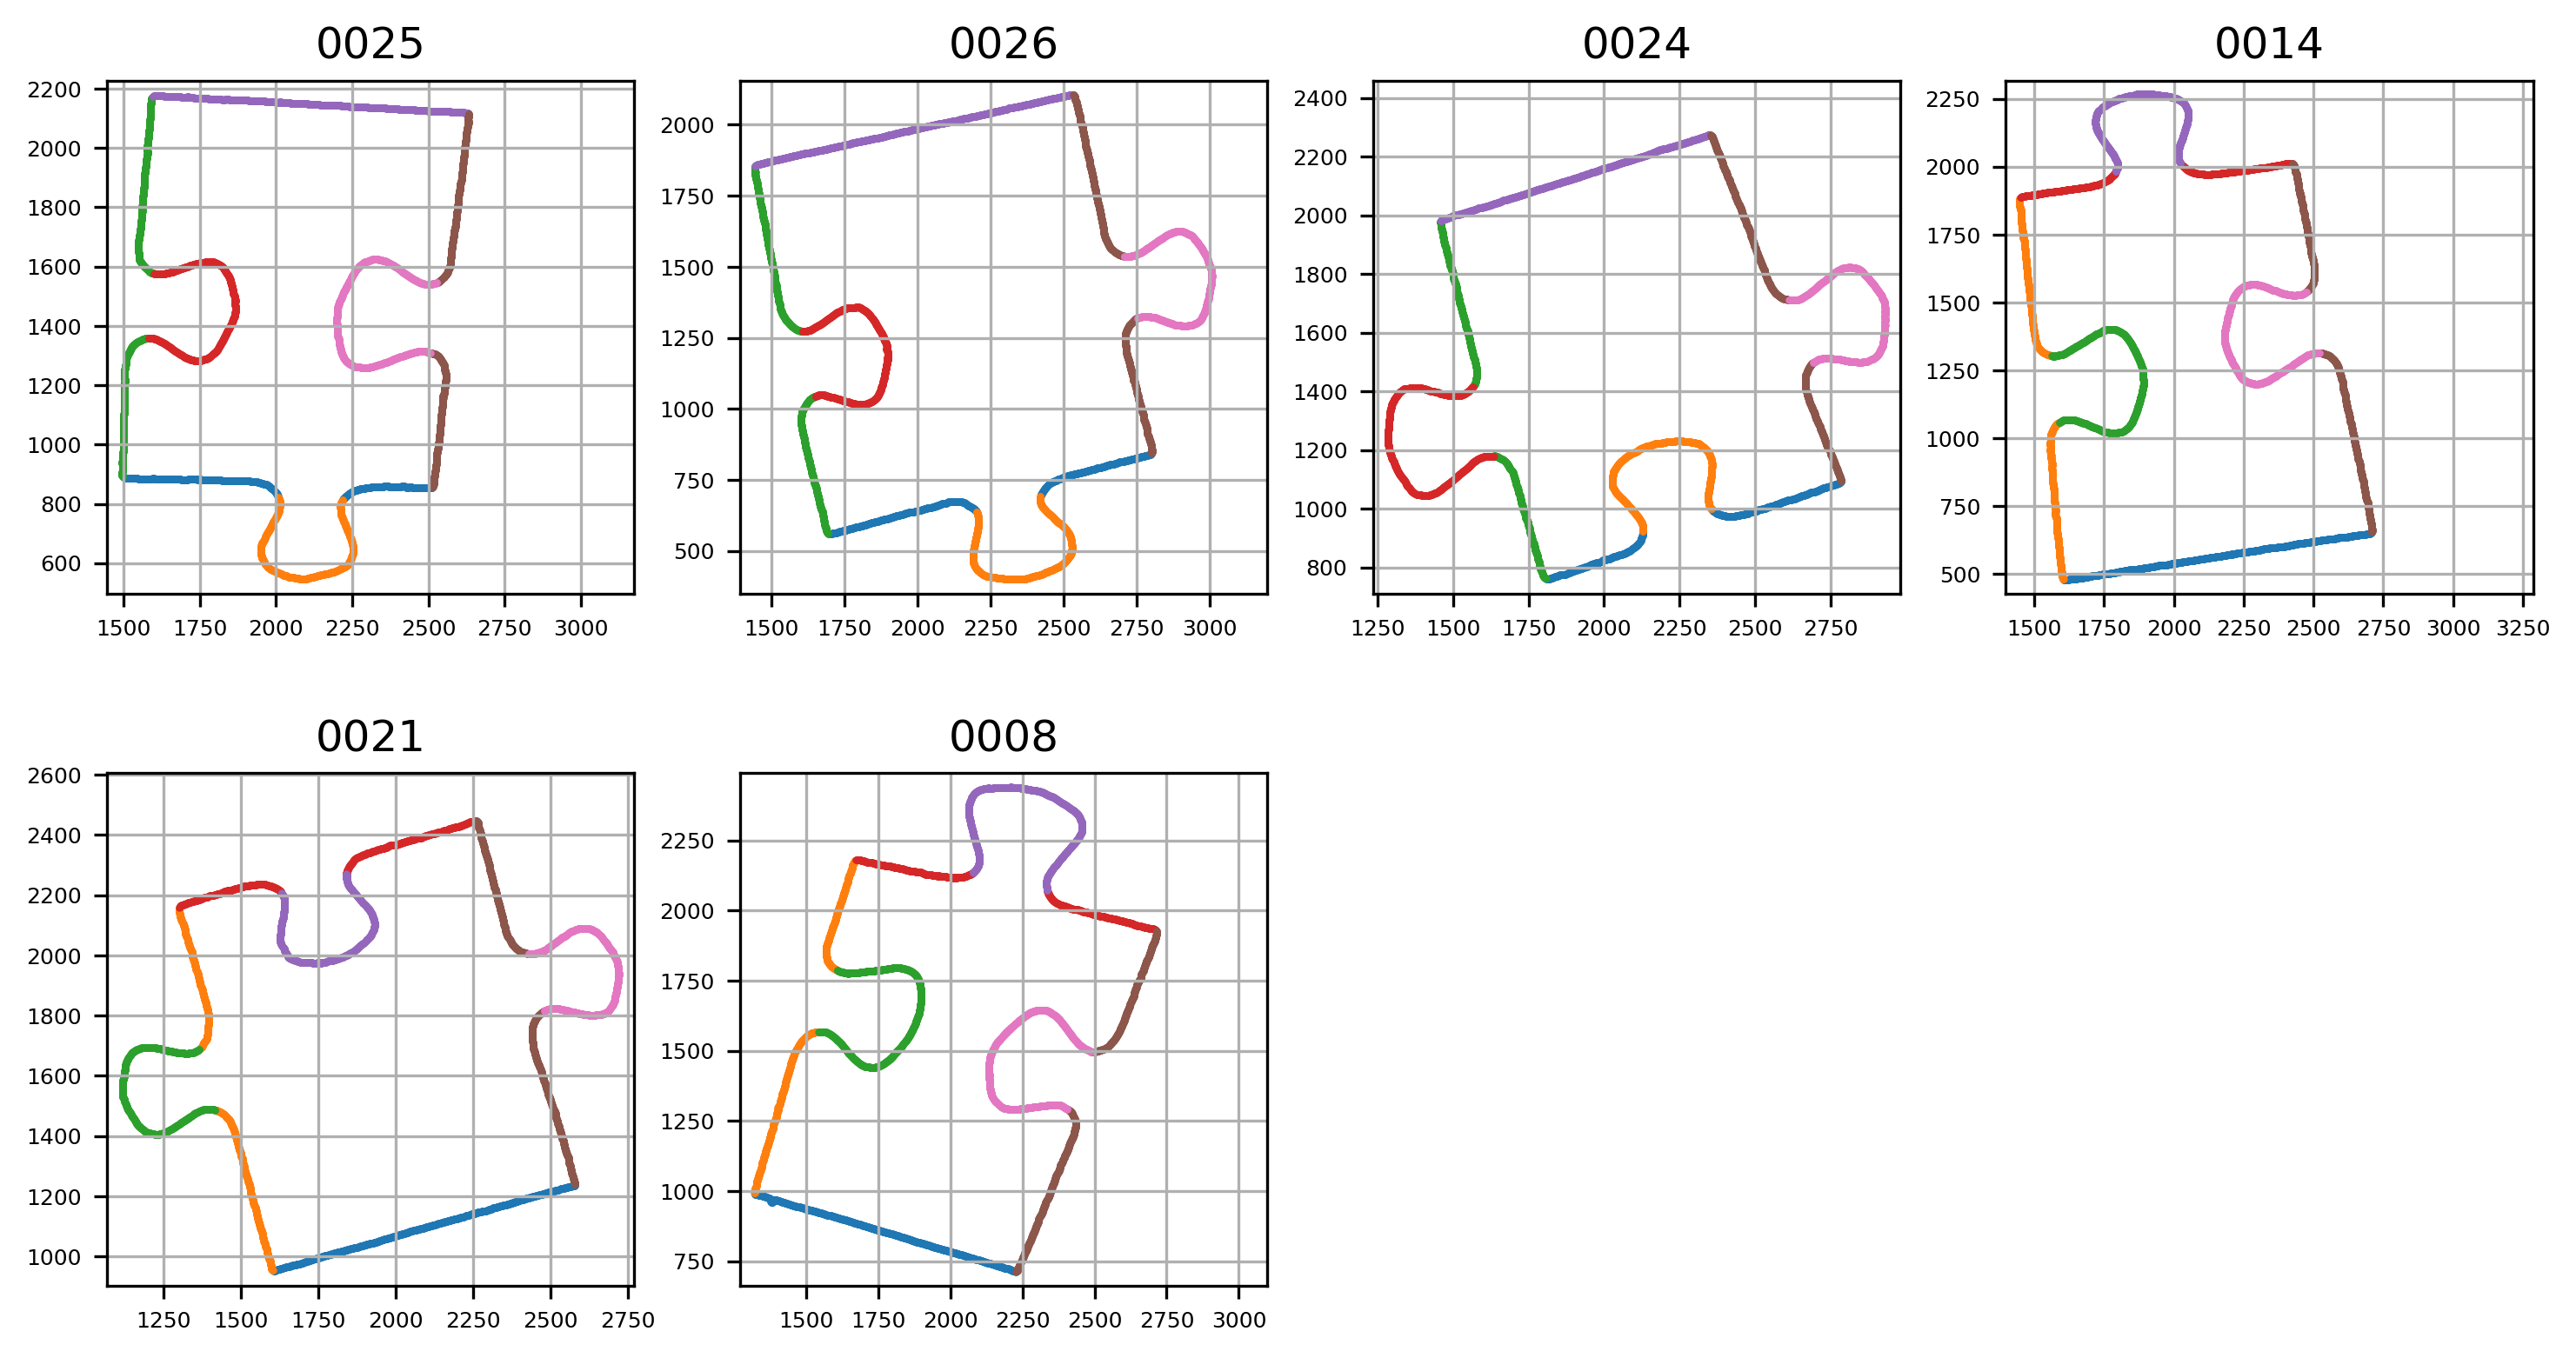

In [8]:
fig, axes = get_figure(len(SAMPLE))

for piece, ax in zip(SAMPLE, axes):
    piece["sides"] = extract_sides(piece["corners"], piece["contour_pixels"])

    lines = []
    for side in piece["sides"]:
        lines.append(side["pixels_d"])
        lines.append(side["pixels_n"])
    ax.set_axis_on()
    scatter_plot_lines(ax, piece["name"], lines)

preview_contents(SAMPLE)

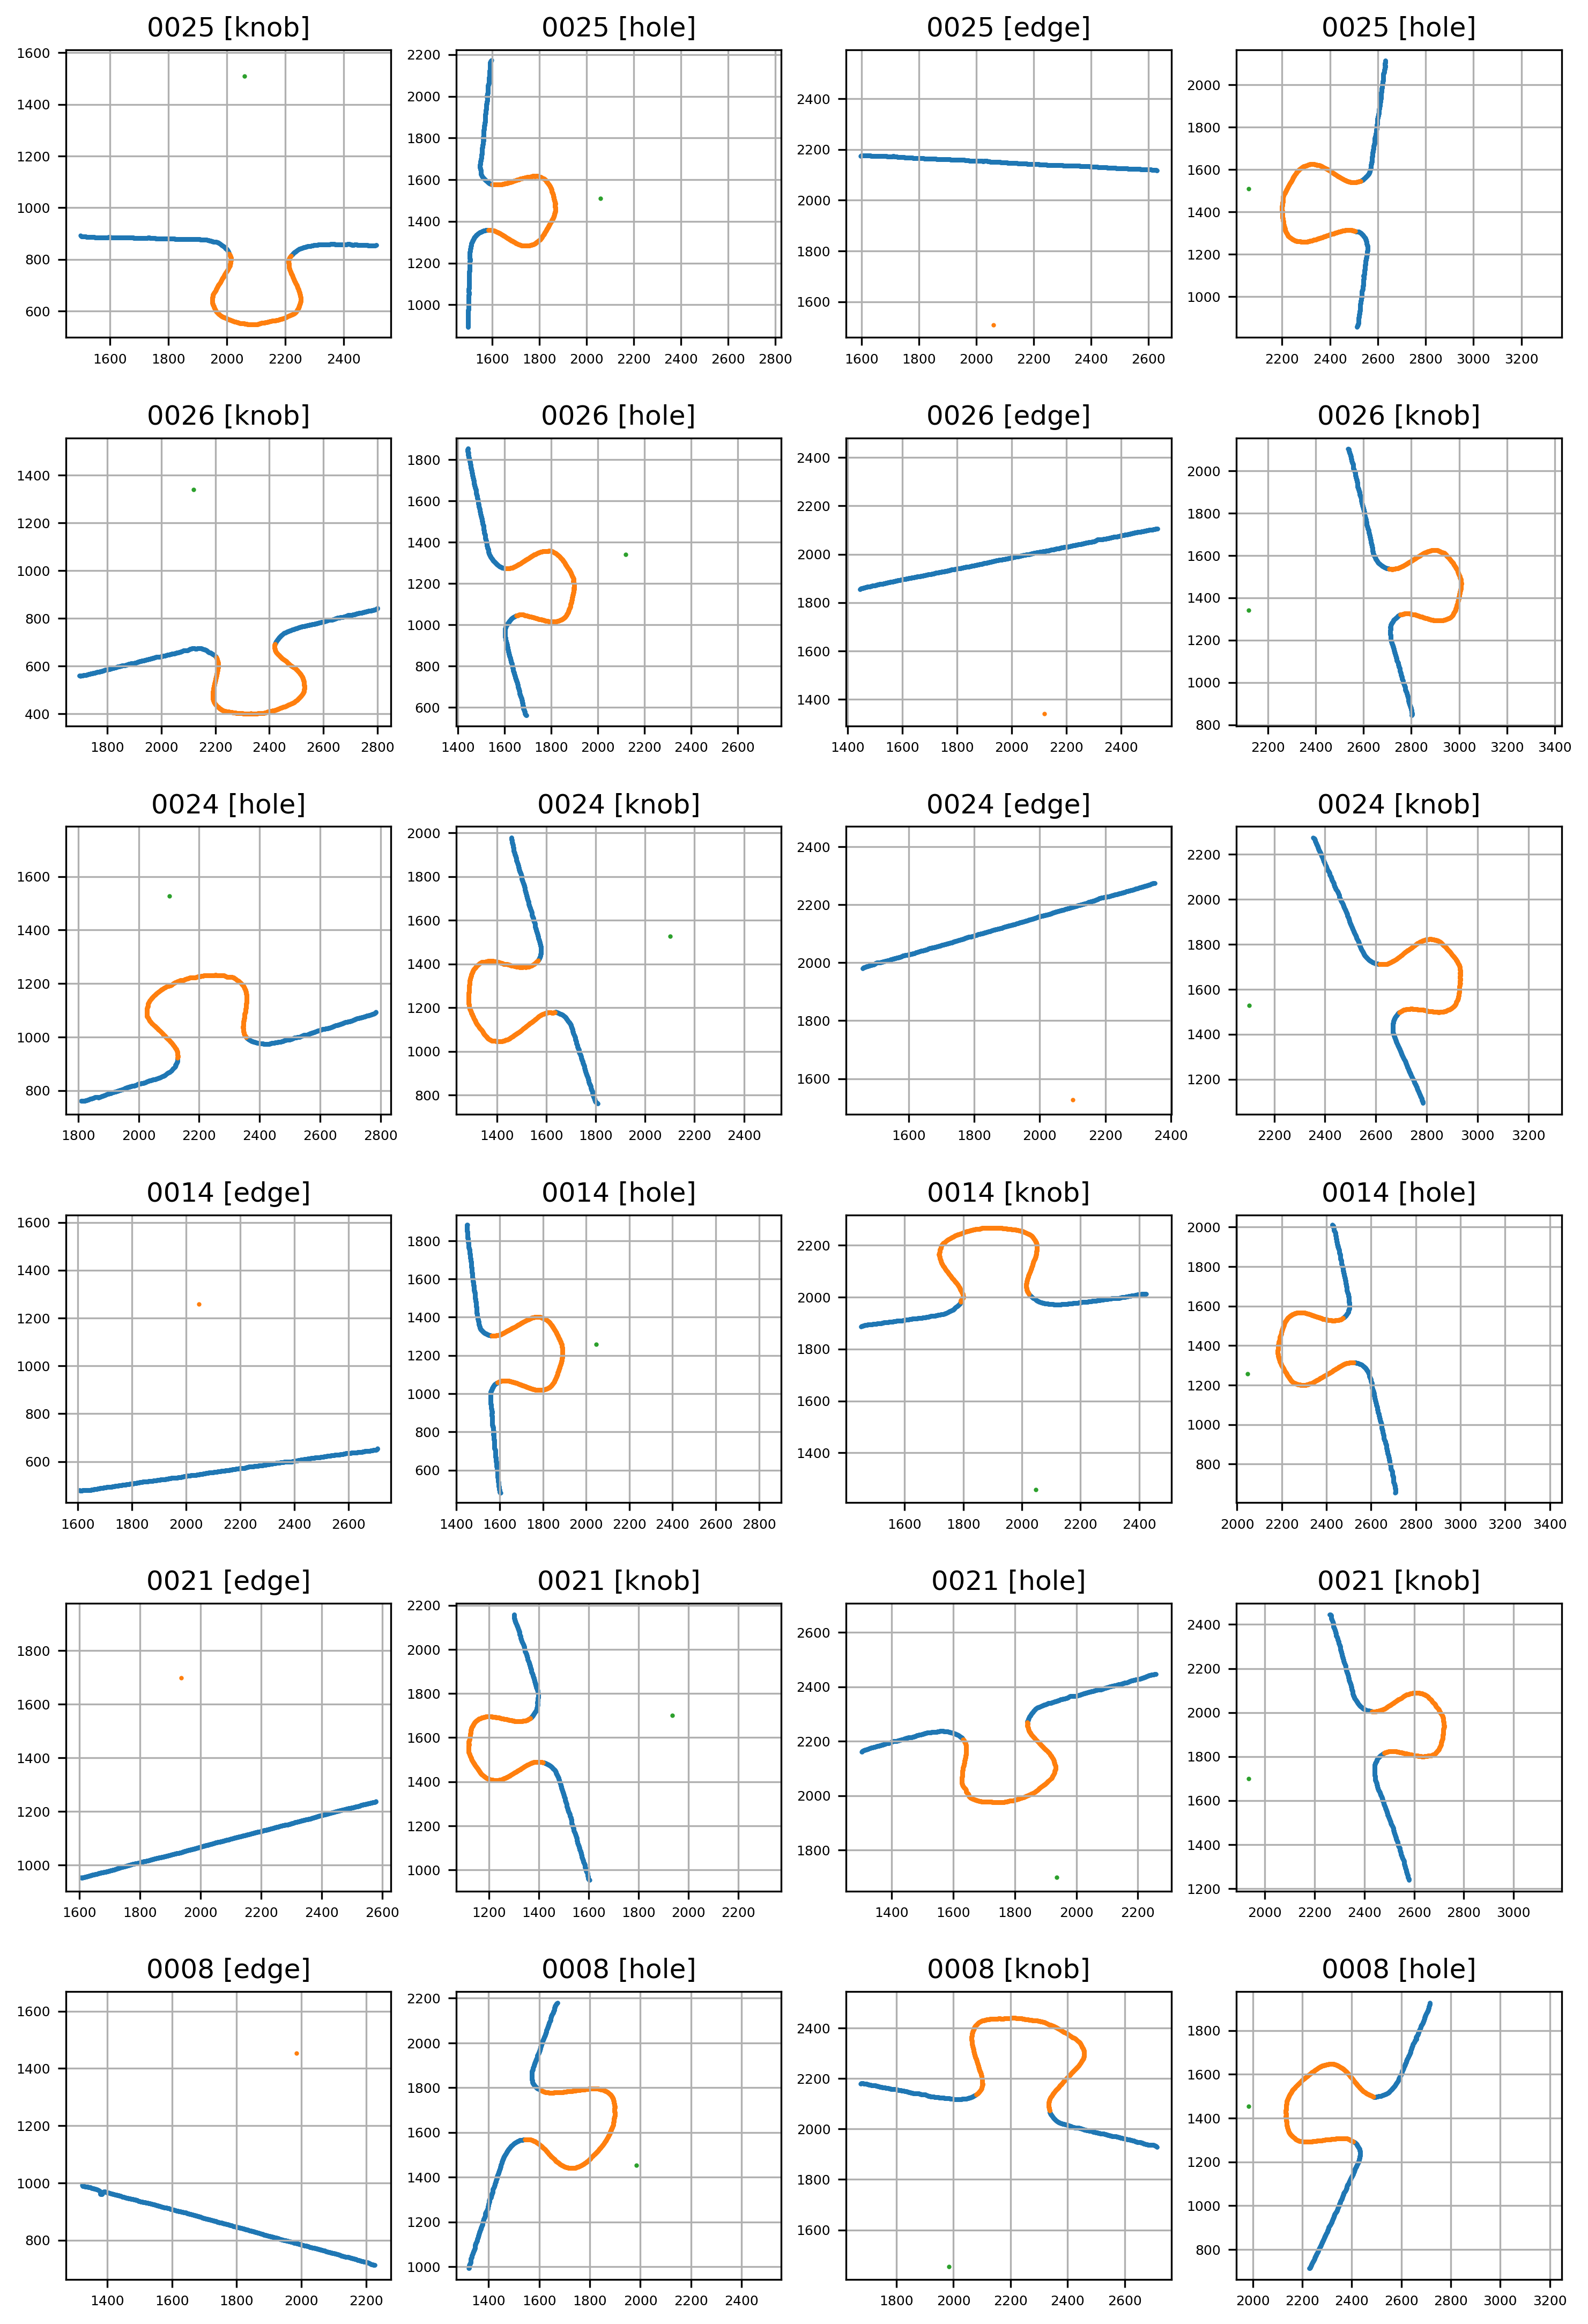

In [9]:
fig, axes = get_figure(len(SAMPLE) * 4)

for piece_idx, piece in enumerate(SAMPLE):
    centroid = _get_centroid(piece["corners"])
    for side_idx, side in enumerate(piece["sides"]):
        ax = axes[piece_idx * 4 + side_idx]
        ax.set_axis_on()

        title = f"{piece['name']} [{side['type']}]"
        scatter_plot_lines(ax, title, [side["pixels_d"], side["pixels_n"], [centroid]])

## Pixel sorting and normalisation

**Step 1:**

For every side of every puzzle piece, select the largest connected component from the side pixels. This step is crucial to eliminate potential noise at the ends of piece sides, near the points where side functions intersect.

**Step 2:**

Sort pixels along the sides to make comparing them later on easier. The sorting process relies on the assumption that edges are always precisely one pixel thick and continous.

**Step 3:**

Rotate and translate sides to roughly the same position in coordinate space (normalize). This step further simplifies side comparison.


In [10]:
_neighbor_coords_f = [
    lambda x, y: (x, y + 1),  # top
    lambda x, y: (x - 1, y),  # left
    lambda x, y: (x + 1, y),  # right
    lambda x, y: (x, y - 1),  # bottom
    lambda x, y: (x - 1, y + 1),  # top-left
    lambda x, y: (x + 1, y + 1),  # top-right
    lambda x, y: (x - 1, y - 1),  # bottom-left
    lambda x, y: (x + 1, y - 1),  # borrom-right
]


def pop_neighbor(pixel: Pixel, pixels: set[Pixel]) -> Pixel:
    x, y = pixel

    for f in _neighbor_coords_f:
        candidate = f(x, y)

        if candidate in pixels:
            pixels.remove(candidate)
            return candidate

    return None


def sort_and_normalize_side_pixels(
    pixels: PixelArray, corners: PointArray
) -> PointArray:
    n_pixels = len(pixels)
    pixels = set(pixels)

    # Step 1: select largest component

    components = []

    while pixels:
        pixel = pixels.pop()
        to_check = [pixel]
        component = {pixel}
        while to_check:
            x, y = to_check.pop()
            for f in _neighbor_coords_f:
                neighbor = f(x, y)

                if neighbor in pixels:
                    pixels.remove(neighbor)
                    to_check.append(neighbor)
                    component.add(neighbor)
        components.append(component)

    largest_component = None
    for component in components:
        if largest_component is None or len(largest_component) < len(component):
            largest_component = component

    # Sanity check (reject no more than 5% of pixels)
    assert (n_pixels - len(largest_component)) / n_pixels < 0.05

    pixels = largest_component

    # Step 2: sort pixels

    start = pixels.pop()  # this can be any point
    ordered = [start]
    pixel = start
    _reversed = False

    while pixel:
        neighbor = pop_neighbor(pixel, pixels)

        if neighbor is None:
            if not _reversed:
                _reversed = True
                ordered.reverse()
                pixel = start
                continue

            break

        ordered.append(neighbor)
        pixel = neighbor

    assert len(pixels) == 0

    # Step 3: translate and rotate to normalize

    ca, cb = corners

    # Translate points to first corner
    points_t = [(p[0] - ca[0], p[1] - ca[1]) for p in ordered]

    # Rotate based on side function
    rotation_angle_rad = math.atan2(ca[0] - cb[0], ca[1] - cb[1]) + math.pi
    points_tr = [
        (
            p[0] * math.cos(rotation_angle_rad) - p[1] * math.sin(rotation_angle_rad),  # fmt: skip
            p[1] * math.cos(rotation_angle_rad) + p[0] * math.sin(rotation_angle_rad),  # fmt: skip
        )
        for p in points_t
    ]

    # Translate above x axis
    min_y = min(p[1] for p in points_tr)
    points_trt = [(p[0], p[1] - min_y) for p in points_tr]

    return points_trt

[{'contour_pixels': ((<class 'int'>,),),
  'corners': ((<class 'float'>,),),
  'name': <class 'str'>,
  'sides': [{'corners': ((<class 'float'>,),),
             'pixels': [(<class 'int'>,)],
             'pixels_d': [(<class 'int'>,)],
             'pixels_n': [(<class 'int'>,)],
             'points_normalized': [(<class 'float'>,)],
             'type': <class 'str'>},
            {'corners': ((<class 'float'>,),),
             'pixels': [(<class 'int'>,)],
             'pixels_d': [(<class 'int'>,)],
             'pixels_n': [],
             'points_normalized': [(<class 'float'>,)],
             'type': <class 'str'>}]}]


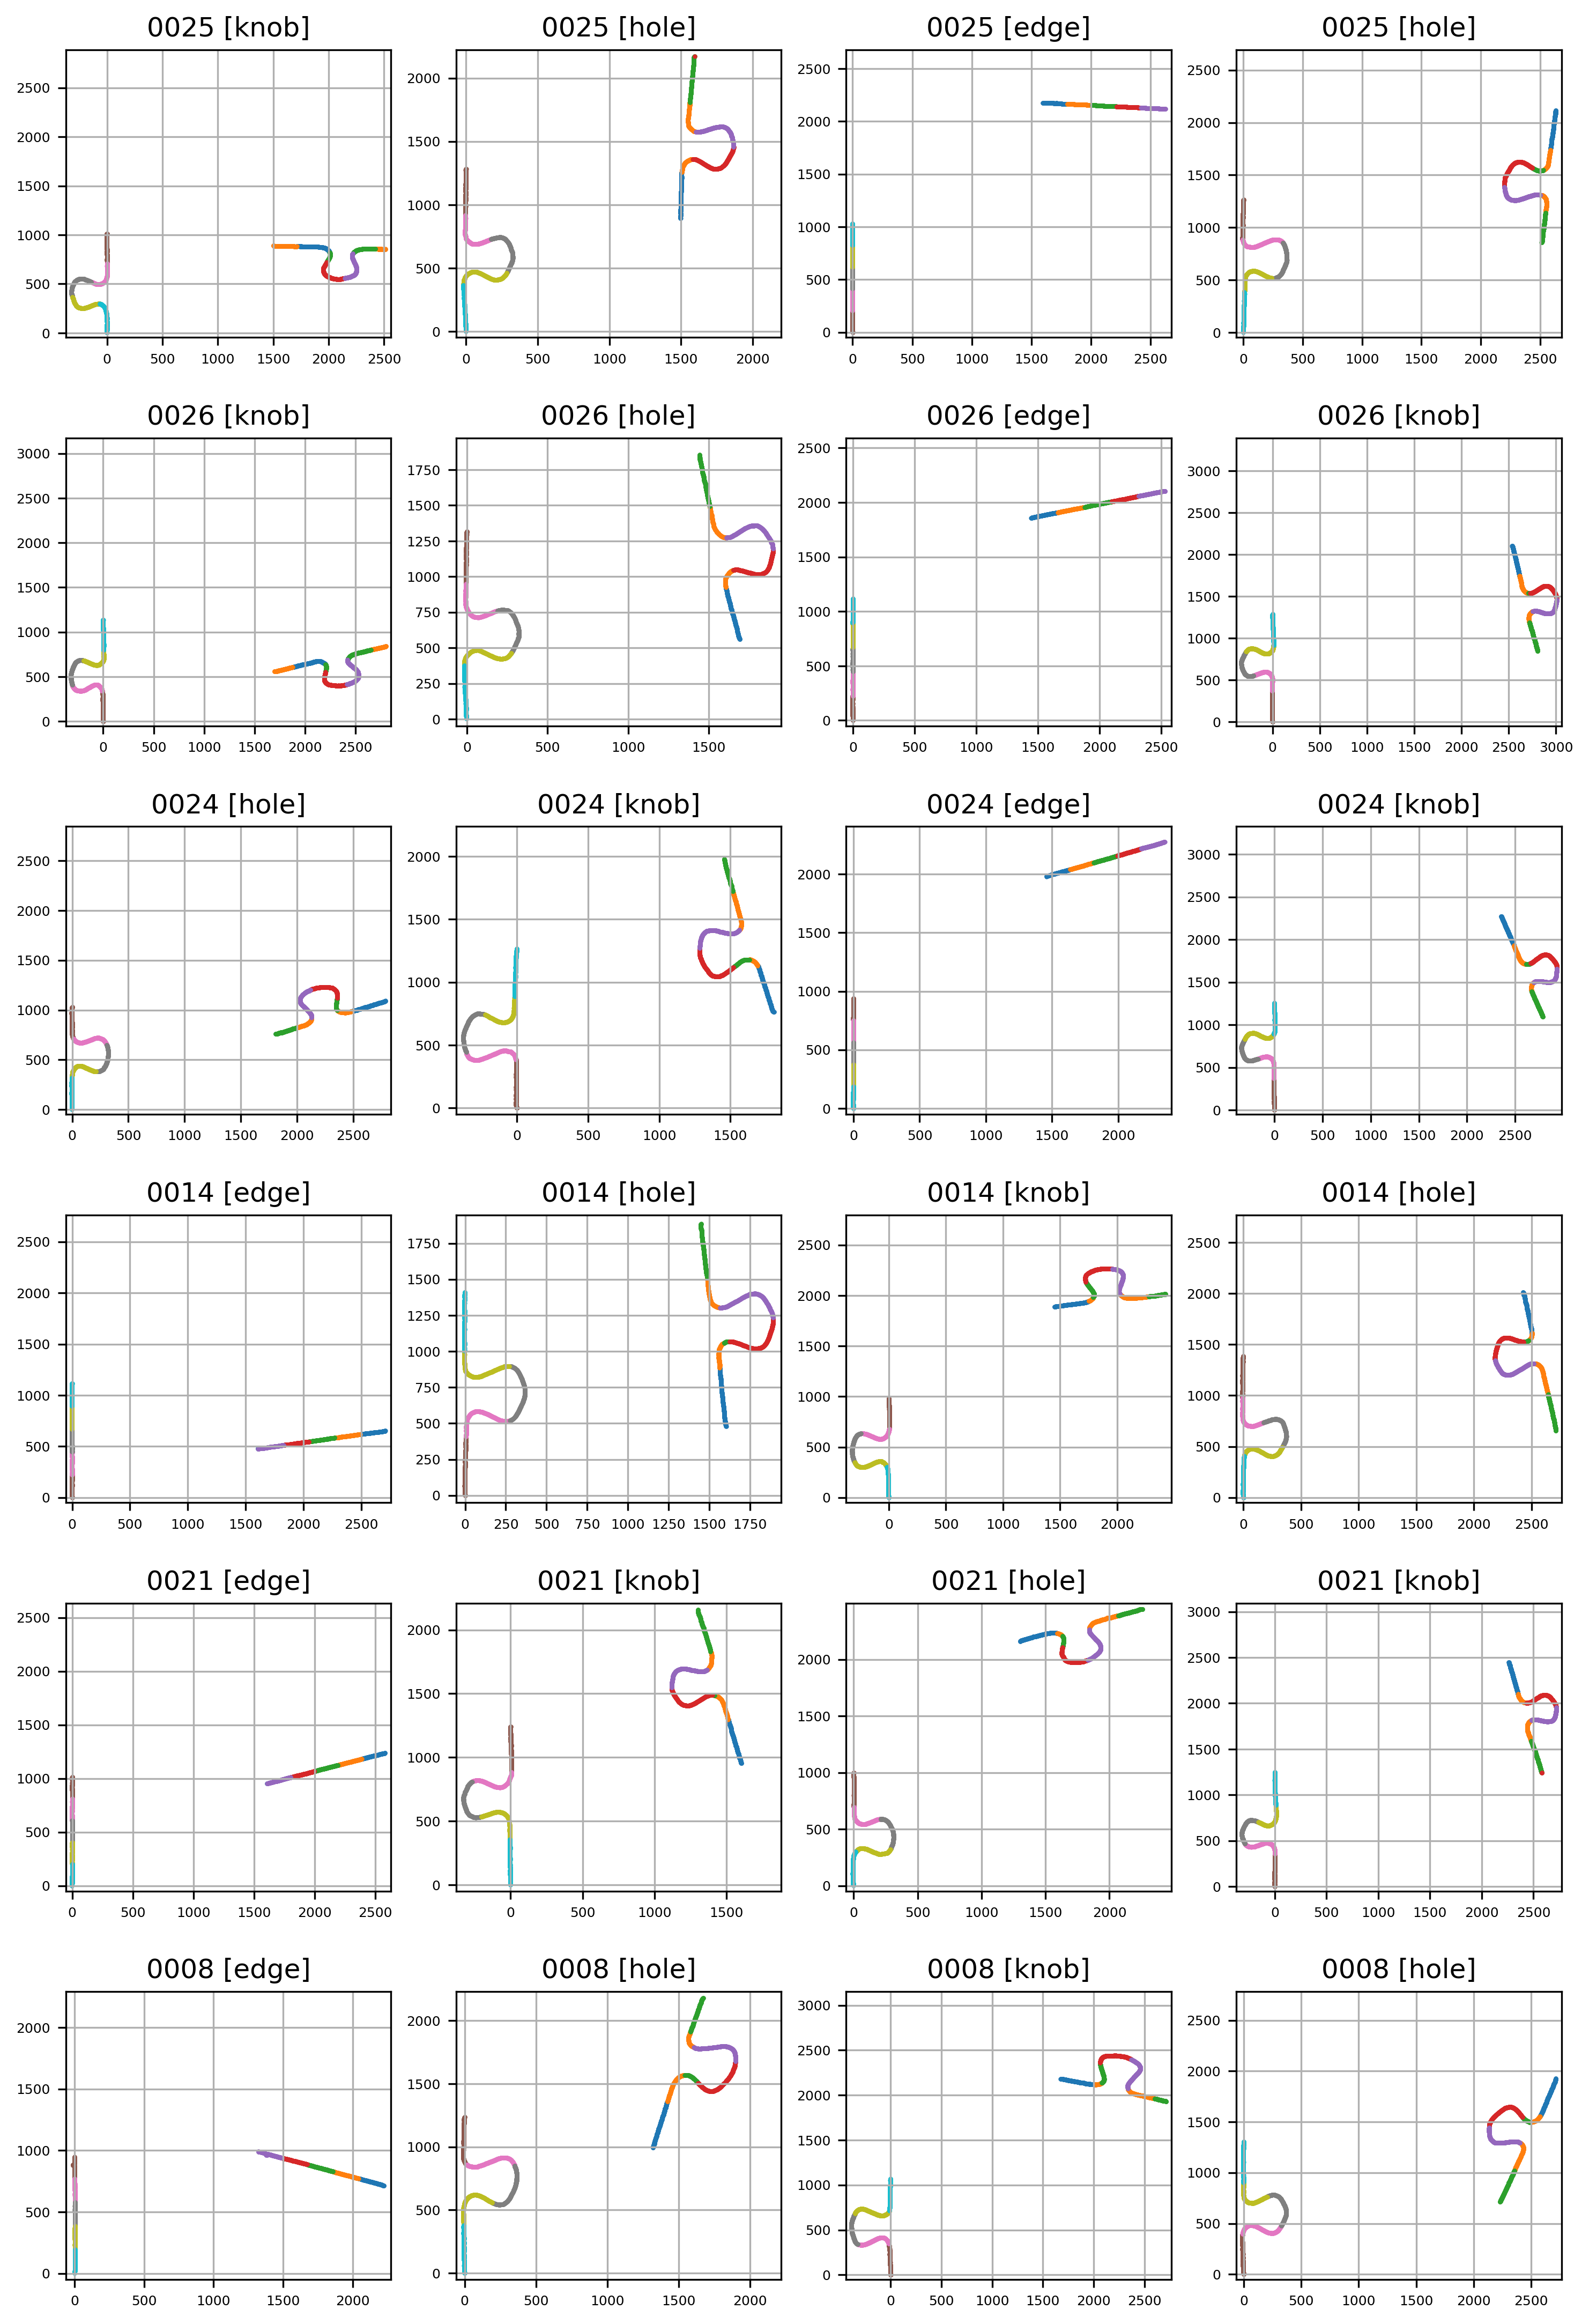

In [11]:
fig, axes = get_figure(len(SAMPLE) * 4)

for piece_idx, piece in enumerate(SAMPLE):
    centroid = _get_centroid(piece["corners"])

    for side_idx, side in enumerate(piece["sides"]):
        side["points_normalized"] = sort_and_normalize_side_pixels(
            side["pixels"], side["corners"]
        )

        ax = axes[piece_idx * 4 + side_idx]
        ax.set_axis_on()

        title = f"{piece['name']} [{side['type']}]"

        steps = 5
        step_size = len(side["points_normalized"]) // steps

        scatter_plot_lines(
            ax,
            title,
            [
                *[
                    side["pixels"][i * step_size : (i + 1) * step_size]
                    for i in range(steps)
                ],
                *[
                    side["points_normalized"][i * step_size : (i + 1) * step_size]
                    for i in range(steps)
                ],
            ],
        )

preview_contents(SAMPLE)

# Full dataset

In [12]:
out_directory = os.path.join("out", "02")

if os.path.exists(out_directory):
    shutil.rmtree(out_directory)
os.makedirs(out_directory)

OUT = []
for piece in tqdm(DATA):
    sides = extract_sides(piece["corners"], piece["contour_pixels"], keep_subsets=False)
    for side in sides:
        side["points"] = sort_and_normalize_side_pixels(
            side.pop("pixels"), side["corners"]
        )
    OUT.append({"name": piece["name"], "sides": sides})

preview_contents(OUT)

with open(os.path.join(out_directory, "out.pickle"), "wb") as f:
    pickle.dump(OUT, f)

100%|██████████| 40/40 [00:01<00:00, 28.05it/s]


[{'name': <class 'str'>,
  'sides': [{'corners': ((<class 'float'>,),),
             'points': [(<class 'float'>,)],
             'type': <class 'str'>}]}]
